In [1]:
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product
import math

def get_fingerprint(smiles, r=3, nBits=1024):
    compound = Chem.MolFromSmiles(smiles.strip())
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits=nBits)
    m = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint,m)
    return m


def sequence_to_kmer(protein_seq, k):
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range(0, len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range(0, len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct, ind))
    
    V=np.zeros(int((math.pow(7,k))))
    try:
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]] += 1
    except:
        count={'1':0,'2':0,'3':0, '4':0, '5':0,'6':0,'7':0}
        for q in range(0,len(protein_seq)):
            if protein_seq[q]=='A' or protein_seq[q]=='V' or protein_seq[q]=='G':
                count['1']+=1
            if protein_seq[q]=='I' or protein_seq[q]=='L'or protein_seq[q]=='F' or protein_seq[q]=='P':
                count['2']+=1
            if protein_seq[q]=='Y' or protein_seq[q]=='M'or protein_seq[q]=='T' or protein_seq[q]=='S':
                count['3']+=1
            if protein_seq[q]=='H' or protein_seq[q]=='N'or protein_seq[q]=='Q' or protein_seq[q]=='W':
                count['4']+=1
            if protein_seq[q]=='R' or protein_seq[q]=='K':
                count['5']+=1
            if protein_seq[q]=='D' or protein_seq[q]=='E':
                count['6']+=1
            if protein_seq[q]=='C':
                count['7']+=1
        
        value=list(count.values())
        key=list(count.keys())
        maximum_occurence=0
        index=0
        for t in range(0, len(value)):
            if maximum_occurence < value[t]:
                maximum_occurence = value[t]
                index=t
        maximum_occurence = key[index] # group number of maximum occuring group
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                if kmer[l] not in groups:
                    c += maximum_occurence
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]] += 1
            
        V = V/(len(protein_seq)-1)
        return np.array(V)
    

def get_protein_features(protein_sequence):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f = []
    protein_info = ProteinAnalysis(str(protein_sequence))
    protein_info.molecular_weight()
    amino_acid_percent = protein_info.get_amino_acids_percent()
    dp = []
    for a in aa:
        dp.append(amino_acid_percent[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    twomer=np.array(sequence_to_kmer(str(protein_sequence), 2))
    twomer=normalize(np.atleast_2d(twomer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(twomer[0])
    threemer=np.array(sequence_to_kmer(str(protein_sequence), 3))
    threemer=normalize(np.atleast_2d(threemer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(threemer[0])
    return np.array(f)

In [2]:
# import pandas as pd

# warhead_df = pd.read_csv("warhead.csv")
# uniprots = np.array(warhead_df["Uniprot"])
# smiles_strings = np.array(warhead_df["Smiles"])
# dataset = warhead_df[["Smiles", "Uniprot"]]
# dataset = np.array(dataset)
# print(dataset.shape)

# print(uniprots.shape)
# print(smiles_strings.shape)

In [3]:
# import requests as r
# from Bio import SeqIO
# from io import StringIO
# import time
# from tqdm import tqdm as tqdm
# import random

# def convert_uniprot_to_sequence(uniprot_list):
#     sequences = []

#     for prot in tqdm(uniprot_list):
#         cID = prot
#         baseUrl = "http://www.uniprot.org/uniprot/"
#         currentUrl = baseUrl+cID+".fasta"
#         response = r.post(currentUrl)
#         cData = ''.join(response.text)
#         cData = str(cData).split("\n")
#         seq = ""
#         for i in range(len(cData)):
#             if i == 0:
#                 continue
#             else:
#                 seq += cData[i]

#         sequences.append(seq)
#         time.sleep(0.1) 
        
#     return np.array(sequences)
# print(dataset[:,1])
# protein_sequences = convert_uniprot_to_sequence(dataset[:,1])

# X = []
# for protein, compound in zip(protein_sequences, dataset[:,0]):
#     x = [compound, protein, float(1)]
#     X.append(x)
    
# X = np.array(X)
# print(len(X))
# print(X[0])

In [4]:
# from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel, polynomial_kernel
# import matplotlib.pyplot as plt

# def generate_negative_examples(negative_ratio, dataset, protein_sequences, compound_smiles, alpha):
#     negative_examples = []

#     while len(negative_examples) < (len(dataset)*negative_ratio):
#         max_protein = -999
#         max_compound = -999
#         random_protein = random.choice(protein_sequences)
#         random_compound = random.choice(compound_smiles)
#         pair = (random_compound, random_protein)
#         if pair not in dataset:
#             for p in protein_sequences:
#                 if (p != random_protein):
#                     prot_feature = get_protein_features(p)
#                     myProtein = get_protein_features(random_protein)
#                     temp = rbf_kernel(prot_feature.reshape(1, -1), myProtein.reshape(1, -1), gamma=0.2)
#                     if (temp > max_protein):
#                         max_protein = temp
#             for c in compound_smiles:
#                 if (c != random_compound):
#                     comp_fingerprint = get_fingerprint(c)
#                     myCompound = get_fingerprint(random_compound)
#                     temp = rbf_kernel(comp_fingerprint.reshape(1, -1), myCompound.reshape(1, -1), gamma=0.02)
#                     if (temp > max_compound):
#                         max_compound = temp
#             value = max_protein * max_compound
#             if value < alpha:
#                 if pair not in negative_examples:        
#                     neg_ex = [random_compound, random_protein, float(0)]
#                     negative_examples.append(neg_ex)
#                     print(len(negative_examples))
#             else:
#                 print("rejected")

#     negative_examples = np.array(negative_examples)
#     print("found negative proteins")
#     sequences = negative_examples[:,1]    
#     compounds = negative_examples[:,0]
#     neg_labels = negative_examples[:,2]
    
#     results = []
#     for comp, seq, l in zip(compounds, sequences, neg_labels):
#         r = [comp, seq, l]
#         results.append(r)

#     return np.array(results)
    
# l = []
# for smiles, prot in zip(smiles_strings, protein_sequences):
#     t = (smiles, prot)
#     l.append(t)
# print(l[0])
# print(protein_sequences[0])
# print(smiles_strings[0])
# negative_examples = generate_negative_examples(1, l, protein_sequences, smiles_strings, 0.2)
# print(negative_examples[0])
# print(negative_examples.shape)
# print(X.shape)
# print(X[0])

In [5]:
# dataset = np.concatenate((X, negative_examples), axis=0)
# print(dataset.shape)
# print(dataset[0])
# np.random.shuffle(dataset)
# print(dataset[0])

In [6]:
# f = open("protac_alpha_20.txt", "w")

# for ex in dataset:
#     f.write(ex[0] + " " + ex[1] + " " + ex[2] + "\n")
# f.close()

In [7]:
# START FROM HERE if you have a file with (protein_sequence, smiles_string, label) as an example
# Data files already generated. 
# STARTING POINT OF PROGRAM

# extract protein features
protein_sequence = []
smiles_string = []
labels = []
f = open("data_for_kernel_cpi_on_protac_db/protac_alpha_20.txt", "r")
lines = f.readlines()

print(len(lines))
for i in range(len(lines)):
    l = lines[i].split(" ")
    compound, protein, label = l

    protein_sequence.append(protein)
    smiles_string.append(compound)
    labels.append(label)
    
print(len(protein_sequence), " ", len(smiles_string), " ", len(labels))
print(smiles_string[0], " ", protein_sequence[0], " ", labels[0])

# convert labels to float for precision recall score
Y = []
for l in labels:
    Y.append(float(l))

labels = np.array(Y)

protein_features = []
for p in protein_sequence:
    prot = get_protein_features(p)
    protein_features.append(prot)
    
protein_features = np.array(protein_features)

compound_fingerprints = []
for c in smiles_string:
    comp = get_fingerprint(c)
    compound_fingerprints.append(comp)
    
compound_fingerprints = np.array(compound_fingerprints)

print(len(protein_sequence))
print(protein_sequence[256], " ", smiles_string[256], " ", labels[256])
# print(protein_features.shape)
# print(protein_features[0])
# print(compound_fingerprints.shape)
# print(compound_fingerprints[0])

2208
2208   2208   2208
CCS(=O)(=O)NC1=CC=C(OC2=CC=C(F)C=C2F)C(C2=CN(C)C(=O)C3=C2C=C[NH]3)=C1   MFGKRKKRVEISAPSNFEHRVHTGFDQHEQKFTGLPRQWQSLIEESARRPKPLVDPACITSIQPGAPKTIVRGSKGAKDGALTLLLDEFENMSVTRSNSLRRDSPPPPARARQENGMPEEPATTARGGPGKAGSRGRFAGHSEAGGGSGDRRRAGPEKRPKSSREGSGGPQESSRDKRPLSGPDVGTPQPAGLASGAKLAAGRPFNTYPRADTDHPSRGAQGEPHDVAPNGPSAGGLAIPQSSSSSSRPPTRARGAPSPGVLGPHASEPQLAPPACTPAAPAVPGPPGPRSPQREPQRVSHEQFRAALQLVVDPGDPRSYLDNFIKIGEGSTGIVCIATVRSSGKLVAVKKMDLRKQQRRELLFNEVVIMRDYQHENVVEMYNSYLVGDELWVVMEFLEGGALTDIVTHTRMNEEQIAAVCLAVLQALSVLHAQGVIHRDIKSDSILLTHDGRVKLSDFGFCAQVSKEVPRRKSLVGTPYWMAPELISRLPYGPEVDIWSLGIMVIEMVDGEPPYFNEPPLKAMKMIRDNLPPRLKNLHKVSPSLKGFLDRLLVRDPAQRATAAELLKHPFLAKAGPPASIVPLMRQNRTR   0.0

2208
MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAASAAPPGASLLLLQQQQQQQQQQQQQQQQQQQQQQQETSPRQQQQQQGEDGSPQAHRRGPTGYLVLDEEQQPSQPQSALECHPERGCVPEPGAAVAASKGLPQQLPAPPDEDDSAAPSTLSLLGPTFPGLSSCSADLKDILSEASTMQLLQQQQQEAVSEGSSSGRAREASGAPTSSKDNYLGGTSTISDNAKELCKAVSVSMGLGVEALEHLSPGEQLRGDCMYAPLLGVPPAVRPTPCAPLAECKGSLLDDSAG

In [8]:
# count = 0
# my_protein = []
# ids = []
# f = open("proteins_alpha_20_cd_hit.fasta", "w")
# for p in protein_sequence:
#     my_protein.append(p)
#     ids.append(count)
#     f.write(">" + str(count) + " <unknown description>" + "\n") # header line for each protein
#     f.write(p + "\n")
#     count += 1
    
# f.close()

count = 0
ids = []
for p in protein_sequence:
    ids.append(count)
    count += 1

In [9]:
import random

def process_cd_hit(file):
    with open(file, "r") as fh:
        clusters = fh.readlines()
    proteins_in_cluster = {}
    for cluster in clusters:

        s = cluster.split()
        if s[0] == '>Cluster':
            cluster_id = int(s[1])
            proteins_in_cluster[cluster_id] = []
        else:
            protein_id = s[2][1:].split('...')[0]
            proteins_in_cluster[cluster_id].append(protein_id)
    protein_to_cluster = {}
    for cluster, protein_list in proteins_in_cluster.items():
        for protein in protein_list:
            protein_to_cluster[protein] = cluster
    return protein_to_cluster

def NRCV(protein_ids, protein_cluster_assignments, K=5):
    # if at index 5, value is 11 then protein with id 5 is assigned to cluster 11
    protein_cluster_index = [] # index of array is protein id
    
    for protein in protein_ids:
        protein_cluster_index.append(protein_cluster_assignments[str(protein)])
    cluster2index = {}
    # use protein_cluster_index to create a dictionary with clusters as keys and their protein_ids as items
    for i, cluster_index in enumerate(protein_cluster_index): 
        try:
            cluster2index[cluster_index].append(i)
        except:
            cluster2index[cluster_index] = [i]
    # dict with cluster_id as key and number of members of that cluster as items
    cluster_counts = dict([(cluster, len(cluster2index[cluster])) for cluster in cluster2index])
    fold_count = [0]*K
    clusters_in_fold = [[] for _ in range(K)]
    example_index_in_fold = [[] for _ in range(K)]
    clusters = list(cluster_counts.keys())
    for cluster in clusters:
        cluster_size = cluster_counts[cluster]
        index = np.argmin(fold_count) # find fold with smallest number of examples
        fold_count[index]+= cluster_size # add cluster size to the size of the fold the cluster is assigned to
        clusters_in_fold[index].append(cluster) # add cluster id to the fold it was assigned to
        example_index_in_fold[index].extend(cluster2index[cluster]) # add index of example to appropriate fold
    return example_index_in_fold
    
protein_to_cluster = process_cd_hit("data_for_kernel_cpi_on_protac_db/proteins_alpha_20_out.cdhit.clstr")
fold_list = NRCV(ids, protein_to_cluster, K=5)
# for f in fold_list:
#     print(f)

In [10]:
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel, polynomial_kernel
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, precision_score
    
except_1  = np.concatenate((fold_list[1], fold_list[2], fold_list[3], fold_list[4]))
except_2  = np.concatenate((fold_list[4], fold_list[0], fold_list[2], fold_list[3]))
except_3  = np.concatenate((fold_list[4], fold_list[1], fold_list[0], fold_list[3]))
except_4  = np.concatenate((fold_list[4], fold_list[1], fold_list[2], fold_list[0]))
except_5  = np.concatenate((fold_list[0], fold_list[1], fold_list[2], fold_list[3]))

test_folds = [1,2,3,4,5]

accuracy_scores = []
auc_roc_scores = []
pr_curve_scores = []

fold_no = 1
for num in test_folds:
    if num == 1:
        train_index = except_1
        test_index = fold_list[0]
    elif num == 2:
        train_index = except_2
        test_index = fold_list[1]
    elif num == 3:
        train_index = except_3
        test_index = fold_list[2]
    elif num == 4:
        train_index = except_4
        test_index = fold_list[3]
    elif num == 5:
        train_index = except_5
        test_index = fold_list[4]

    compounds_train, proteins_train = np.array(compound_fingerprints[train_index]), np.array(protein_features[train_index])
    compounds_test, proteins_test = np.array(compound_fingerprints[test_index]), np.array(protein_features[test_index])
    y_train, y_test = np.array(labels[train_index]), np.array(labels[test_index])

    compounds_scaler = StandardScaler().fit(compounds_train)
    proteins_scaler = StandardScaler().fit(proteins_train)

    compounds_scaled = compounds_scaler.transform(compounds_train)
    proteins_scaled = proteins_scaler.transform(proteins_train)

    protein_kernel = polynomial_kernel(proteins_scaled, gamma=0.001, degree=2) # tune, try other kernels, keep same gamma between train and test
    compound_kernel = polynomial_kernel(compounds_scaled, gamma=0.001, degree=2)
    combined_kernel = (protein_kernel+compound_kernel)**2

    clf = SVC(C = 1.0, kernel = "precomputed")
    clf.fit(combined_kernel, y_train)

    compounds_test_scaled = compounds_scaler.transform(compounds_test)
    proteins_test_scaled = proteins_scaler.transform(proteins_test)

    protein_test_kernel = polynomial_kernel(proteins_test_scaled, proteins_scaled, gamma=0.001, degree=2)
    compound_test_kernel = polynomial_kernel(compounds_test_scaled, compounds_scaled, gamma=0.001, degree=2)
    combined_test_kernel = (protein_test_kernel+compound_test_kernel)**2

    predictions = clf.decision_function(combined_test_kernel)
    accuracy_predictions = clf.predict(combined_test_kernel) # binary labels cannot be handled by decision function for accuracy and precision-recall
    ACCURACY = accuracy_score(y_test, accuracy_predictions)
    AUC_ROC = roc_auc_score(y_test, predictions)
    PR_SCORE = average_precision_score(y_test, predictions)
    accuracy_scores.append(ACCURACY)
    auc_roc_scores.append(AUC_ROC)
    pr_curve_scores.append(PR_SCORE)

    print("Fold ", fold_no, " results: ", "accuracy ", ACCURACY, " auc_roc: ", AUC_ROC, " precision_recall: ", PR_SCORE)
    fold_no += 1

Fold  1  results:  accuracy  0.7963800904977375  auc_roc:  0.8543846358592166  precision_recall:  0.8833206925821779
Fold  2  results:  accuracy  0.7873303167420814  auc_roc:  0.8265028161802356  precision_recall:  0.8670351437300212
Fold  3  results:  accuracy  0.7873303167420814  auc_roc:  0.8460198750128061  precision_recall:  0.8764406815410954
Fold  4  results:  accuracy  0.7981859410430839  auc_roc:  0.850557452585675  precision_recall:  0.8615600627374481
Fold  5  results:  accuracy  0.8231292517006803  auc_roc:  0.8821599537801255  precision_recall:  0.8956682259888878


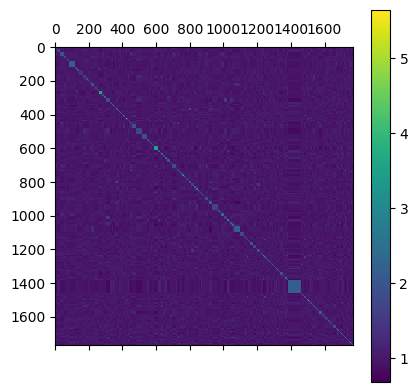

In [11]:
import matplotlib.pyplot as plt
plt.matshow(protein_kernel)
plt.colorbar()

In [12]:
print("Accuracy of model: ", np.mean(accuracy_scores))
print("AUC-ROC of model: ", np.mean(auc_roc_scores))
print("PR-CURVE of model: ", np.mean(pr_curve_scores))

Accuracy of model:  0.798471183345133
AUC-ROC of model:  0.8519249466836119
PR-CURVE of model:  0.8768049613159261


In [13]:
# e3_df = pd.read_csv("e3_ligand.csv")
# e3_proteins = e3_df["Uniprot"]
# e3_smiles = e3_df["Smiles"]
# e3_dataset = np.array(e3_df[["Smiles", "Uniprot"]])
# print(e3_dataset.shape)

# print(e3_proteins.shape)
# print(e3_smiles.shape)

In [14]:
# print(e3_dataset[:,1])
# e3_sequences = convert_uniprot_to_sequence(e3_dataset[:,1])

# e3_X = []
# for protein, compound in zip(e3_sequences, dataset[:,0]):
#     e3_x = [compound, protein, float(1)]
#     e3_X.append(e3_x)

# e3_X = np.array(e3_X)
# print(len(e3_X))
# print(e3_X[0])

In [15]:
# e3_list = []
# for smiles, prot in zip(e3_smiles, e3_sequences):
#     e3_t = (smiles, prot)
#     e3_list.append(e3_t)
# print(e3_list[0])
# print(e3_sequences[0])
# print(e3_smiles[0])
# e3_negative_examples = generate_negative_examples(1, e3_list, e3_sequences, e3_smiles, 0.2)
# print(e3_negative_examples[0])
# print(e3_negative_examples.shape)
# print(e3_X.shape)
# print(e3_X[0])

In [16]:
# e3_dataset = np.concatenate((e3_X, e3_negative_examples), axis=0)
# print(e3_dataset.shape)
# print(e3_dataset[0])
# np.random.shuffle(e3_dataset)
# print(e3_dataset[0])

In [17]:
# f = open("e3_alpha_20.txt", "w")

# for ex in e3_dataset:
#     f.write(ex[0] + " " + ex[1] + " " + ex[2] + "\n")
# f.close()

In [18]:
# extract protein features
e3_protein_sequence = []
e3_smiles_string = []
e3_labels = []
f = open("data_for_kernel_cpi_on_protac_db/e3_alpha_20.txt", "r")
lines = f.readlines()

print(len(lines))
for i in range(len(lines)):
    l = lines[i].split(" ")
    compound, protein, label = l

    e3_protein_sequence.append(protein)
    e3_smiles_string.append(compound)
    e3_labels.append(label)
    
print(len(e3_protein_sequence), " ", len(e3_smiles_string), " ", len(e3_labels))
print(e3_smiles_string[0], " ", e3_protein_sequence[0], " ", e3_labels[0])

# convert labels to float for precision recall score
e3_Y = []
for l in e3_labels:
    e3_Y.append(float(l))

e3_labels = np.array(e3_Y)

e3_protein_features = []
for p in e3_protein_sequence:
    prot = get_protein_features(p)
    e3_protein_features.append(prot)
    
e3_protein_features = np.array(e3_protein_features)

e3_compound_fingerprints = []
for c in e3_smiles_string:
    comp = get_fingerprint(c)
    e3_compound_fingerprints.append(comp)
    
e3_compound_fingerprints = np.array(e3_compound_fingerprints)

print(len(e3_protein_sequence))
print(e3_protein_sequence[100], " ", e3_smiles_string[100], " ", e3_labels[100])

180
180   180   180
CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1C[C@H]2CC[C@@H]1N(CCC1=CC=CC=C1)C2)C1CCCCC1   MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQTLPLQLFHPQEVSMVRNLIQKDRTFAVLAYSNVQEREAQFGTTAEIYAYREEQDFGIEIVKVKAIGRQRFKVLELRTQSDGIQQAKVQILPECVLPSTMSAVQLESLNKCQIFPSKPVSREDQCSYKWWQKYQKRKFHCANLTSWPRWLYSLYDAETLMDRIKKQLREWDENLKDDSLPSNPIDFSYRVAACLPIDDVLRIQLLKIGSAIQRLRCELDIMNKCTSLCCKQCQETEITTKNEIFSLSLCGPMAAYVNPHGYVHETLTVYKACNLNLIGRPSTEHSWFPGYAWTVAQCKICASHIGWKFTATKKDMSPQKFWGLTRSALLPTIPDTEDEISPDKVILCL   0.0

180
MAGEGDQQDAAHNMGNHLPLLPAESEEEDEMEVEDQDSKEAKKPNIINFDTSLPTSHTYLGADMEEFHGRTLHDDDSCQVIPVLPQVMMILIPGQTLPLQLFHPQEVSMVRNLIQKDRTFAVLAYSNVQEREAQFGTTAEIYAYREEQDFGIEIVKVKAIGRQRFKVLELRTQSDGIQQAKVQILPECVLPSTMSAVQLESLNKCQIFPSKPVSREDQCSYKWWQKYQKRKFHCANLTSWPRWLYSLYDAETLMDRIKKQLREWDENLKDDSLPSNPIDFSYRVAACLPIDDVLRIQLLKIGSAIQRLRCELDIMNKCTSLCCKQCQETEITTKNEIFSLSLCGPMAAYVNPHGYVHETLTVYKACNLNLIGRPSTEHSWFPGYAWTVAQCKICASHIGWKFTATKKDMSPQKFWGLTRSALLPTIPDTEDEISPDKVILCL   

In [19]:
# count = 0
# e3_my_protein = []
# e3_ids = []
# f = open("e3_alpha_20_cd_hit.fasta", "w")
# for p in e3_protein_sequence:
#     e3_my_protein.append(p)
#     e3_ids.append(count)
#     f.write(">" + str(count) + " <unknown description>" + "\n") # header line for each protein
#     f.write(p + "\n")
#     count += 1
    
# f.close()

count = 0
e3_ids = []
for p in e3_protein_sequence:
    e3_ids.append(count)
    count += 1

In [20]:
e3_protein_to_cluster = process_cd_hit("data_for_kernel_cpi_on_protac_db/e3_alpha_20_out.cdhit.clstr")
fold_list = NRCV(e3_ids, e3_protein_to_cluster, K=5)

In [21]:
except_1  = np.concatenate((fold_list[1], fold_list[2], fold_list[3], fold_list[4]))
except_2  = np.concatenate((fold_list[4], fold_list[0], fold_list[2], fold_list[3]))
except_3  = np.concatenate((fold_list[4], fold_list[1], fold_list[0], fold_list[3]))
except_4  = np.concatenate((fold_list[4], fold_list[1], fold_list[2], fold_list[0]))
except_5  = np.concatenate((fold_list[0], fold_list[1], fold_list[2], fold_list[3]))

test_folds = [1,2,3,4,5]

accuracy_scores = []
auc_roc_scores = []
pr_curve_scores = []

fold_no = 1
for num in test_folds:
    if num == 1:
        train_index = except_1
        test_index = fold_list[0]
    elif num == 2:
        train_index = except_2
        test_index = fold_list[1]
    elif num == 3:
        train_index = except_3
        test_index = fold_list[2]
    elif num == 4:
        train_index = except_4
        test_index = fold_list[3]
    elif num == 5:
        train_index = except_5
        test_index = fold_list[4]

    compounds_train, proteins_train = np.array(e3_compound_fingerprints[train_index]), np.array(e3_protein_features[train_index])
    compounds_test, proteins_test = np.array(e3_compound_fingerprints[test_index]), np.array(e3_protein_features[test_index])
    y_train, y_test = np.array(e3_labels[train_index]), np.array(e3_labels[test_index])

    compounds_scaler = StandardScaler().fit(compounds_train)
    proteins_scaler = StandardScaler().fit(proteins_train)

    compounds_scaled = compounds_scaler.transform(compounds_train)
    proteins_scaled = proteins_scaler.transform(proteins_train)

    protein_kernel = polynomial_kernel(proteins_scaled, gamma=0.001, degree=2) # tune, try other kernels, keep same gamma between train and test
    compound_kernel = polynomial_kernel(compounds_scaled, gamma=0.001, degree=2)
    combined_kernel = (protein_kernel+compound_kernel)**2

    clf = SVC(C = 1.0, kernel = "precomputed")
    clf.fit(combined_kernel, y_train)

    compounds_test_scaled = compounds_scaler.transform(compounds_test)
    proteins_test_scaled = proteins_scaler.transform(proteins_test)

    protein_test_kernel = polynomial_kernel(proteins_test_scaled, proteins_scaled, gamma=0.001, degree=2)
    compound_test_kernel = polynomial_kernel(compounds_test_scaled, compounds_scaled, gamma=0.001, degree=2)
    combined_test_kernel = (protein_test_kernel+compound_test_kernel)**2

    predictions = clf.decision_function(combined_test_kernel)
    accuracy_predictions = clf.predict(combined_test_kernel) # binary labels cannot be handled by decision function for accuracy and precision-recall
    ACCURACY = accuracy_score(y_test, accuracy_predictions)
    AUC_ROC = roc_auc_score(y_test, predictions)
    PR_SCORE = average_precision_score(y_test, predictions)
    accuracy_scores.append(ACCURACY)
    auc_roc_scores.append(AUC_ROC)
    pr_curve_scores.append(PR_SCORE)

    print("Fold ", fold_no, " results: ", "accuracy ", ACCURACY, " auc_roc: ", AUC_ROC, " precision_recall: ", PR_SCORE)
    fold_no += 1

Fold  1  results:  accuracy  1.0  auc_roc:  1.0  precision_recall:  1.0
Fold  2  results:  accuracy  0.9285714285714286  auc_roc:  0.9758828596037898  precision_recall:  0.9644957376168495
Fold  3  results:  accuracy  0.9615384615384616  auc_roc:  1.0  precision_recall:  1.0
Fold  4  results:  accuracy  1.0  auc_roc:  1.0  precision_recall:  0.9999999999999998
Fold  5  results:  accuracy  1.0  auc_roc:  1.0  precision_recall:  1.0


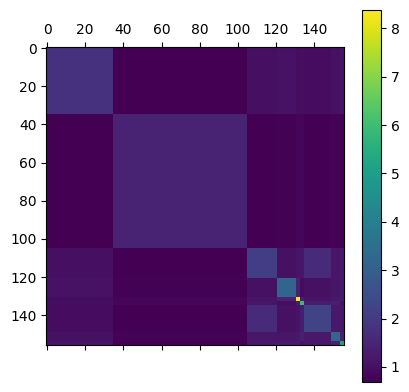

In [22]:
import matplotlib.pyplot as plt
plt.matshow(protein_kernel)
plt.colorbar()

In [23]:
print("Accuracy of model: ", np.mean(accuracy_scores))
print("AUC-ROC of model: ", np.mean(auc_roc_scores))
print("PR-CURVE of model: ", np.mean(pr_curve_scores))

Accuracy of model:  0.9780219780219781
AUC-ROC of model:  0.9951765719207579
PR-CURVE of model:  0.9928991475233699
